In [38]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from matplotlib import pyplot as plt
import seaborn as sns

import joblib

import mlflow
import mlflow.sklearn

import boto3

## Upload and look at Data

In [5]:
df = pd.read_csv("../archive/Heart_Prediction_Quantum_Dataset.csv")
df.head(5)

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
0,68,1,105,191,107,8.362241,1
1,58,0,97,249,89,9.249002,0
2,44,0,93,190,82,7.942542,1
3,72,1,93,183,101,6.495155,1
4,37,0,145,166,103,7.653900,1


In [6]:
df.describe()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,54.864000,0.468000,132.874000,221.50000,88.766000,8.317407,0.600000
std,14.315004,0.499475,26.418516,43.86363,17.417289,0.919629,0.490389
min,30.000000,0.000000,90.000000,150.00000,60.000000,6.164692,0.000000
25%,43.000000,0.000000,111.000000,183.75000,73.000000,7.675779,0.000000
50%,55.000000,0.000000,132.000000,221.00000,89.000000,8.323064,1.000000
75%,66.250000,1.000000,155.000000,258.00000,104.000000,8.935999,1.000000
max,79.000000,1.000000,179.000000,299.00000,119.000000,10.784886,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    500 non-null    int64  
 1   Gender                 500 non-null    int64  
 2   BloodPressure          500 non-null    int64  
 3   Cholesterol            500 non-null    int64  
 4   HeartRate              500 non-null    int64  
 5   QuantumPatternFeature  500 non-null    float64
 6   HeartDisease           500 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 27.5 KB


In [8]:
df.shape

(500, 7)

In [9]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
df_reduced = reduce_mem_usage(df)
df_reduced.info()

Memory usage of dataframe is 0.03 MB
Memory usage after optimization is: 0.00 MB
Decreased by 81.8%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    500 non-null    int8   
 1   Gender                 500 non-null    int8   
 2   BloodPressure          500 non-null    int16  
 3   Cholesterol            500 non-null    int16  
 4   HeartRate              500 non-null    int8   
 5   QuantumPatternFeature  500 non-null    float16
 6   HeartDisease           500 non-null    int8   
dtypes: float16(1), int16(2), int8(4)
memory usage: 5.0 KB


In [11]:
train_df = df_reduced[:350]
test_df = df_reduced[351:]

In [12]:
X = train_df.drop("HeartDisease", axis=1)
y = train_df["HeartDisease"]

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [30]:
X_test, y_test = test_df.drop("HeartDisease", axis=1), test_df["HeartDisease"]

## Baseline

In [14]:
rc = RidgeClassifier()
rc.fit(X_train, y_train)

baseline_pred = rc.predict(X_val)

In [15]:
accuracy_base = accuracy_score(y_val, baseline_pred)
f1_base = f1_score(y_val, baseline_pred)
roc_auc_base = roc_auc_score(y_val, baseline_pred)

print(f"Accuracy: {accuracy_base}")
print(f"F1-score: {f1_base}")
print(f"ROC AUC score: {roc_auc_base}")

Accuracy: 0.9090909090909091
F1-score: 0.9230769230769231
ROC AUC score: 0.9000523286237572


## EDA

### Duplicates

In [16]:
X_train.duplicated().sum()

np.int64(0)

In [17]:
duplicaated_cols = set()

for i in range(X_train.shape[1]):
    col0 = X_train.iloc[:, i]
    for j in range(i+1, X_train.shape[1]):
        col1 = X_train.iloc[:, j]

        if col0.equals(col1):
            duplicaated_cols.add(X_train.columns.values[j])

duplicaated_cols

set()

In [18]:
const_cols = []

for i in X_train.columns:
    if X_train[i].nunique() == 1:
        const_cols.append[i]

const_cols

[]

In [19]:
id_cols = []

for i in X_train.columns:
    if X_train[i].nunique() == X_train.shape[0]:
        id_cols.append(i)

id_cols

[]

### Missings

In [20]:
missings = X_train.isna().sum().sort_values(ascending=False)
missings

Age                      0
Gender                   0
BloodPressure            0
Cholesterol              0
HeartRate                0
QuantumPatternFeature    0
dtype: int64

### Graphics

In [21]:
y_train.value_counts().values

array([166,  96])

#### Imbalance

In [22]:
random_over = RandomOverSampler(random_state=42)
X_train, y_train = random_over.fit_resample(X_train, y_train)

### Correlations

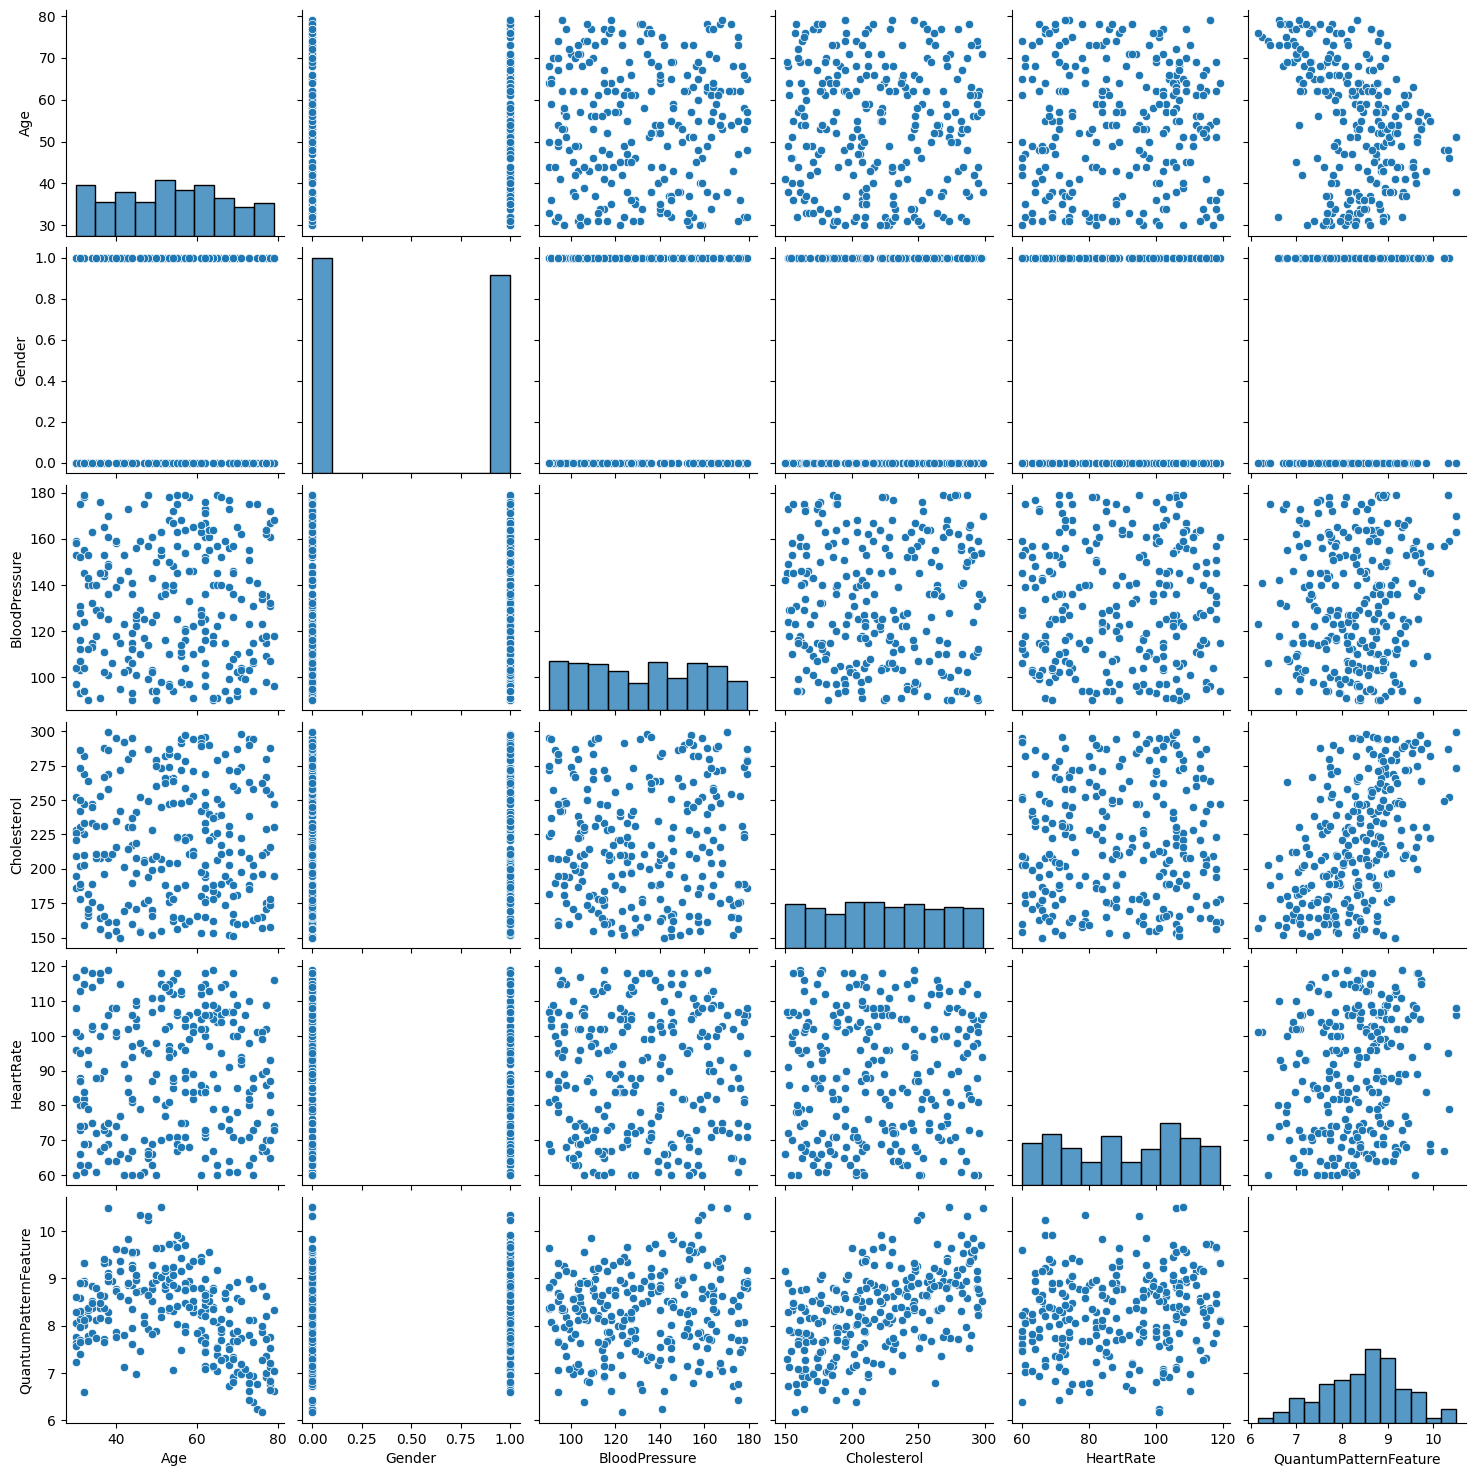

In [23]:
sns.pairplot(X_train)

In [24]:
corr = train_df.corr()

<Axes: >

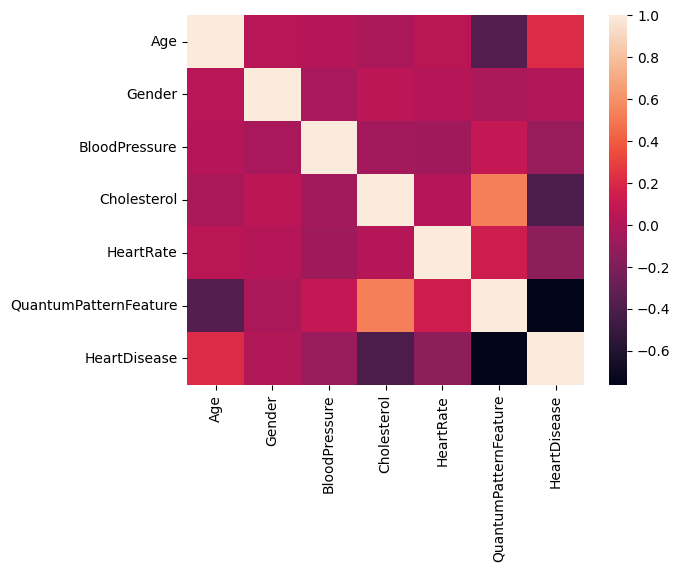

In [25]:
sns.heatmap(corr)

### Normilization

In [26]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=scaler.get_feature_names_out())

In [27]:
X_train

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature
0,0.832456,-0.958684,-0.398270,0.320947,-0.285500,-1.225237
1,-1.532177,-0.958684,1.749868,0.017639,-0.452868,-0.440299
2,0.760801,1.043096,-1.625777,-0.005692,-0.062343,0.371098
3,-1.603832,1.043096,-0.053033,-0.518982,-0.954972,-1.216417
4,-1.388866,-0.958684,-0.666787,0.204290,1.332390,-0.096337
...,...,...,...,...,...,...
327,-0.242377,-0.958684,-1.625777,1.184207,-0.062343,1.332426
328,-0.099066,-0.958684,0.138765,0.880899,0.662918,0.838532
329,0.617489,1.043096,-0.474989,0.740911,-0.341290,0.212346
330,0.545834,-0.958684,1.289553,1.510846,0.662918,1.014923


In [28]:
X_val = scaler.transform(X_val)
X_val = pd.DataFrame(X_val, columns=scaler.get_feature_names_out())

In [29]:
X_val

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature
0,0.904112,-0.958684,-1.433979,1.137544,1.053444,1.173674
1,0.187556,-0.958684,1.788227,-1.125597,-1.345497,0.732698
2,-0.600655,-0.958684,0.100405,0.950893,-0.731815,1.535275
3,0.975767,1.043096,0.905957,-0.822290,0.997654,0.300541
4,-1.460521,1.043096,-1.549058,-0.892284,-1.178129,0.653322
...,...,...,...,...,...,...
83,-0.027410,-0.958684,1.021035,0.927562,0.105025,1.561734
84,-0.457344,1.043096,0.330563,0.577592,0.160814,0.741518
85,-0.528999,-0.958684,0.599080,0.764242,-1.066551,0.856171
86,0.259212,1.043096,1.481351,-0.518982,0.774497,0.450473


## Experiments

In [37]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.get_tracking_uri()

'http://localhost:5000'

In [ ]:
s3_client = boto3.client(
    "s3",
    endpoint_url="http://localhost:9000",
    aws_access_key_id="minio-access-key",
    aws_secret_access_key="minio-secret-key"
)

s3_client.list_buckets()

{'ResponseMetadata': {'RequestId': '1836EB0B74D21572',
  'HostId': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'accept-ranges': 'bytes',
   'content-length': '275',
   'content-type': 'application/xml',
   'server': 'MinIO',
   'strict-transport-security': 'max-age=31536000; includeSubDomains',
   'vary': 'Origin, Accept-Encoding',
   'x-amz-id-2': 'dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8',
   'x-amz-request-id': '1836EB0B74D21572',
   'x-content-type-options': 'nosniff',
   'x-ratelimit-limit': '8034',
   'x-ratelimit-remaining': '8034',
   'x-xss-protection': '1; mode=block',
   'date': 'Wed, 16 Apr 2025 21:52:20 GMT'},
  'RetryAttempts': 0},
 'Buckets': [],
 'Owner': {'DisplayName': 'minio',
  'ID': '02d6176db174dc93cb1b899f7c6078f08654445fe8cf1b6ce98d8855f66bdbf4'}}

### RandomForest

In [ ]:
param_grid = {
    "n_estimators" : [50, 100, 200, 300, 500],
    "max_depth": [3, 5, 7, 10, 15, 22],
    "criterion": ['gini', "entropy", "log_loss"],
    "min_samples_split": np.arange(2,10,2)
}

mlflow.set_experiment("Forest_models")

with mlflow.start_run():
    gc_rf = GridSearchCV(
        param_grid=param_grid,
        estimator=RandomForestClassifier(random_state=42),
        cv=3,
        scoring="roc_auc"
    )

    gc_rf.fit(X_train, y_train)

    mlflow.log_params(gc_rf.best_params_)

    best_model_rf = gc_rf.best_estimator_
    rf_pred = best_model_rf.predict(X_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test, rf_pred))
    mlflow.log_metric("roc-auc", roc_auc_score(y_test, rf_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, rf_pred))

    mlflow.sklearn.log_model(
        sk_model=best_model_rf,
        artifact_path="mlflow-artifacts",
        registered_model_name="Best_RF_Model"
    )

/home/nikifor/Desktop/MLOPs_HD/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
2025/04/17 00:57:29 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: ValueError("could not convert string to float: 'auto'"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
/home/nikifor/Desktop/MLOPs_HD/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
2025/04/17 00:57:31 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": "auto"
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is vali

🏃 View run sedate-stoat-419 at: http://localhost:5000/#/experiments/541640202670926176/runs/ecf301dee4824cf28fe09b409fbe2e81
🧪 View experiment at: http://localhost:5000/#/experiments/541640202670926176


PermissionError: [Errno 13] Permission denied: '/home/mlflow-user'

### Logistic Regression

In [45]:
param_grid = {
    "tol": np.arange(0.0001, 0.0025, 0.0005),
    "C": np.arange(0.1, 2, 0.1),
}

mlflow.set_experiment("Logistic_regression_models")

with mlflow.start_run():
    lr_rf = GridSearchCV(
        param_grid=param_grid,
        estimator=LogisticRegression(random_state=42),
        cv=3,
        scoring="roc_auc"
    )

    lr_rf.fit(X_train, y_train)

    mlflow.log_params(lr_rf.best_params_)

    best_model_lr = lr_rf.best_estimator_
    lr_pred = best_model_lr.predict(X_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test, lr_pred))
    mlflow.log_metric("roc-auc", roc_auc_score(y_test, lr_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, lr_pred))

    mlflow.sklearn.log_model(
        sk_model=best_model_lr,
        artifact_path="mlflow-artifacts",
        registered_model_name="Best_LR_Model"
    )

2025/04/17 01:05:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run worried-elk-948 at: http://localhost:5000/#/experiments/758651907657599765/runs/5f4ecc4b0d8b4c7f901ef55622728f9c
🧪 View experiment at: http://localhost:5000/#/experiments/758651907657599765


PermissionError: [Errno 13] Permission denied: '/home/mlflow-user'